# Setting up the Data

## Setting up Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [3]:
# raw data location
data_path = "rawDataSample.bin"

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

## Loading the data 

In [5]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [6]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

In [7]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# A

## Setting up the data

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(95240, 51)


## Defining the Model

In [9]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        
        first_lin_size = 28*(input_size//seq_len)
        
        self.lstm1 = nn.LSTM(input_size=seq_len, hidden_size=15, num_layers=2)
        self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, 80)
        self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin3 = nn.Linear(embedding_size, 16)
        self.lin4 = nn.Linear(16, 25)
        self.lin5 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x, 3)
        out, _ = self.lstm1(x, hidden)
        out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        out = self.lin1(out)
        out = self.activation_layer(out)
        enc = self.lin2(out)

        out = self.lin3(enc)
        out = self.activation_layer(out)
        out = self.lin4(out)
        out = self.activation_layer(out)
        dec = self.lin5(out)
        return enc, dec
    
    def serialise_input(self, data, seq_len):
        data = data.view(-1, 1, seq_len)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [10]:
def init_lstm_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
    elif type(layer) == nn.LSTM:
        for name, param in layer.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal(param)

In [11]:
import datetime

## Loading Models

In [12]:
lstm_ae_1 = torch.load('models/visapy/lstm_12.pt')
lstm_ae_2 = torch.load('models/visapy/lstm_10.pt')
lstm_ae_3 = torch.load('models/visapy/lstm_8.pt')
lstm_ae_4 = torch.load('models/visapy/lstm_6.pt')
lstm_ae_5 = torch.load('models/visapy/lstm_4.pt')
lstm_ae_6 = torch.load('models/visapy/lstm_2.pt')

## Testing 12-dim embedding

In [11]:
enc_12 = np.zeros([total_sigs, 12])
out_12 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_1.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_12[i, :] = enc[:]
    out_12[i, :] = o[:]

## Testing 10-dim embedding

In [12]:
enc_10 = np.zeros([total_sigs, 10])
out_10 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_2.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_10[i, :] = enc[:]
    out_10[i, :] = o[:]

## Testing 8-dim embedding

In [13]:
enc_8 = np.zeros([total_sigs, 8])
out_8 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_3.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_8[i, :] = enc[:]
    out_8[i, :] = o[:]

## Testing 6-dim embedding

In [14]:
enc_6 = np.zeros([total_sigs, 6])
out_6 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_4.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_6[i, :] = enc[:]
    out_6[i, :] = o[:]

## Testing 4-dim embedding

In [15]:
enc_4 = np.zeros([total_sigs, 4])
out_4 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_5.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_4[i, :] = enc[:]
    out_4[i, :] = o[:]

## Testing 2-dim embedding

In [13]:
a = datetime.datetime.now()

enc_2 = np.zeros([total_sigs, 2])
out_2 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_6.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_2[i, :] = enc[:]
    out_2[i, :] = o[:]
b = datetime.datetime.now()
print(b-a)

0:12:07.506526


In [17]:
def find_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        mse.append(np.mean(se))
    mse = np.array(mse)
  
    if params == 'median':
        return np.median(mse), np.std(mse)
    elif params == 'limits':
        return np.amax(mse), np.amin(mse)
    else:
        return np.median(mse), np.std(mse), np.amax(mse), np.amin(mse)

In [18]:
print(find_mse(electrode_data, out_12))

(34.17109543302704, 101.09307087485011, 4175.306188081744, 4.086676134435483)


In [19]:
print(find_mse(electrode_data, out_10))

(42.7061095509636, 112.81099255154862, 4554.2923465163885, 4.961691813660902)


In [20]:
print(find_mse(electrode_data, out_8))

(54.728085492106885, 117.3229696678656, 5298.109543779495, 5.449400381833102)


In [21]:
print(find_mse(electrode_data, out_6))

(88.64777906812839, 178.4189168800991, 6252.408907469268, 7.284344189888937)


In [22]:
print(find_mse(electrode_data, out_4))

(133.41038533165107, 232.43489867474366, 7836.145627486999, 8.872189944640203)


In [23]:
print(find_mse(electrode_data, out_2))

(249.40267000515058, 296.8712642850611, 8648.185533534708, 22.02211292626158)


In [14]:
from herdingspikes.hs2 import HSClustering
C = HSClustering(H)

def gen_features(enc_data, pca=False):
    C.ShapePCA(pca_ncomponents=2, pca_whiten=True)
    if pca is False:
        print('Updating features from encoded data')
        C.features = enc_data
#print(C.features.shape)

In [15]:
def get_cluster(alpha):
    C.CombinedClustering(alpha=alpha, bandwidth=5., bin_seeding=False, n_jobs=-1)

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
    plt.title("MeanShift, no bin seeding");

In [16]:
gen_features(enc_2)

Fitting PCA using 95240 spikes...
...projecting...
...done
Updating features from encoded data


Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.8min remaining:  5.3min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  1.8min remaining:   22.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.9min finished


Number of estimated units: 549


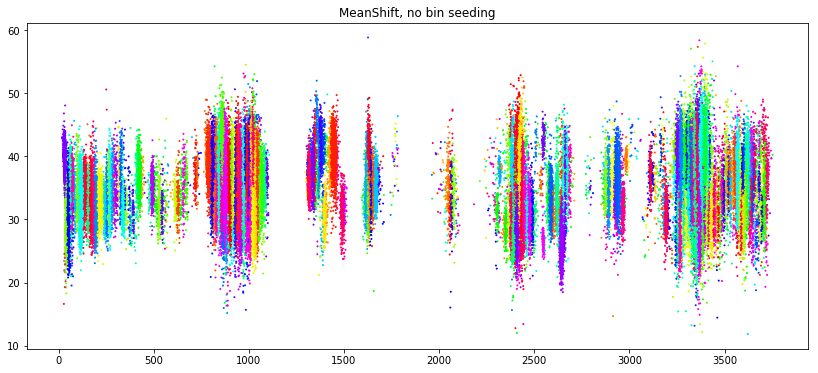

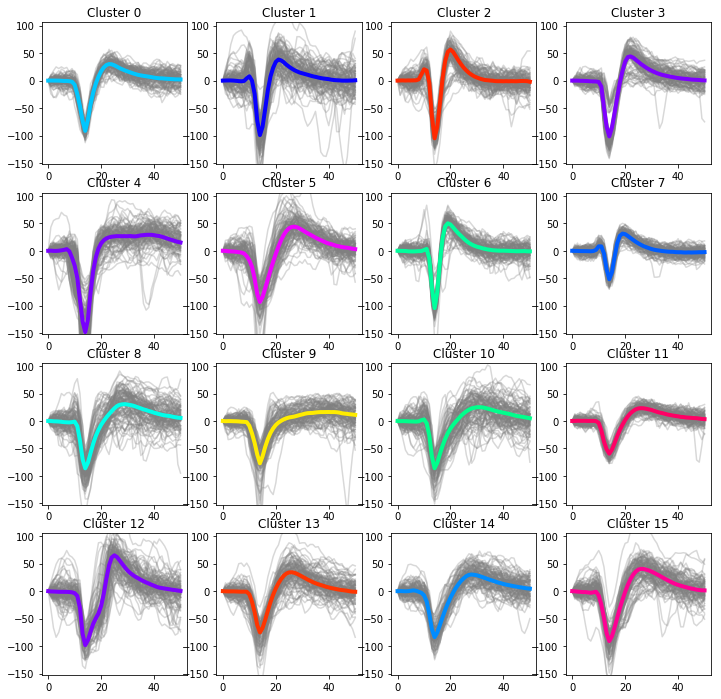

In [17]:
get_cluster(0.25)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.5min remaining:  4.5min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  1.5min remaining:   18.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.6min finished


Number of estimated units: 1399


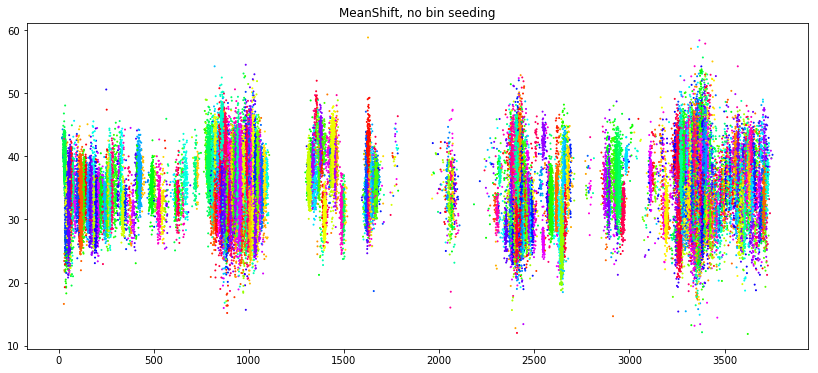

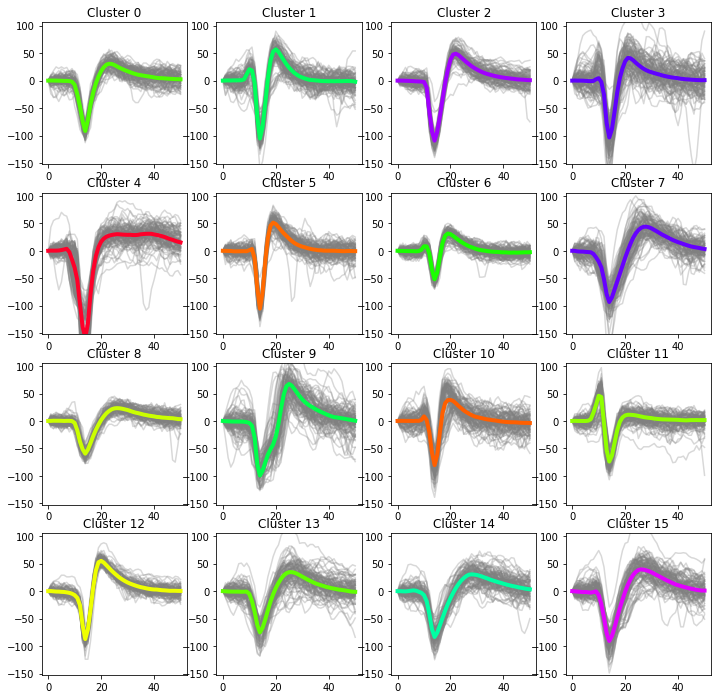

In [28]:
get_cluster(0.5)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.3min remaining:  3.8min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.3min finished


Number of estimated units: 5457


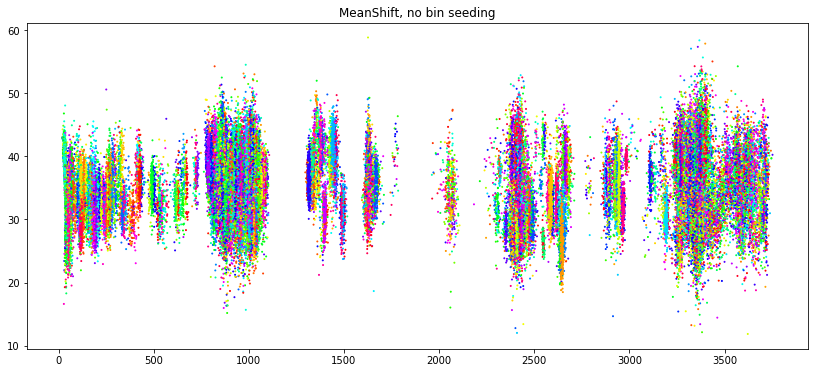

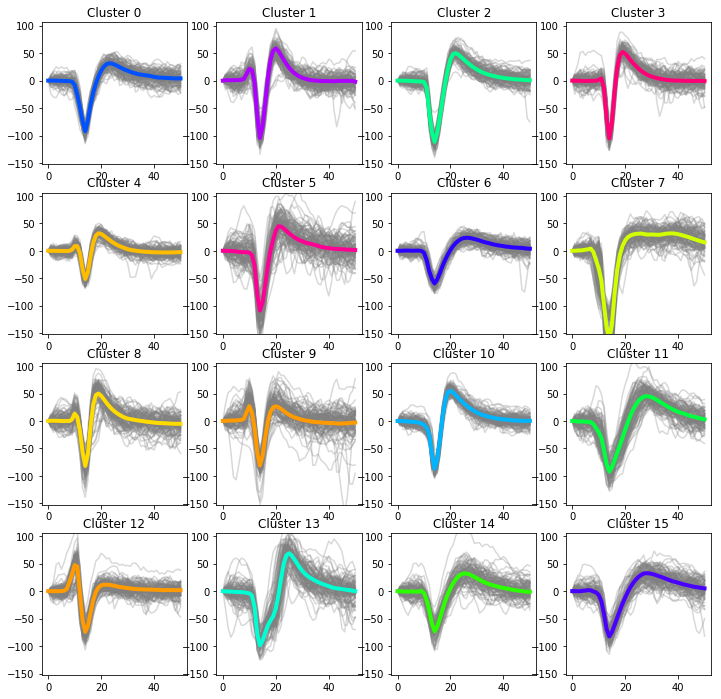

In [29]:
get_cluster(1)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   45.0s remaining:  2.2min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   47.0s remaining:    9.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   47.5s finished


Number of estimated units: 17030


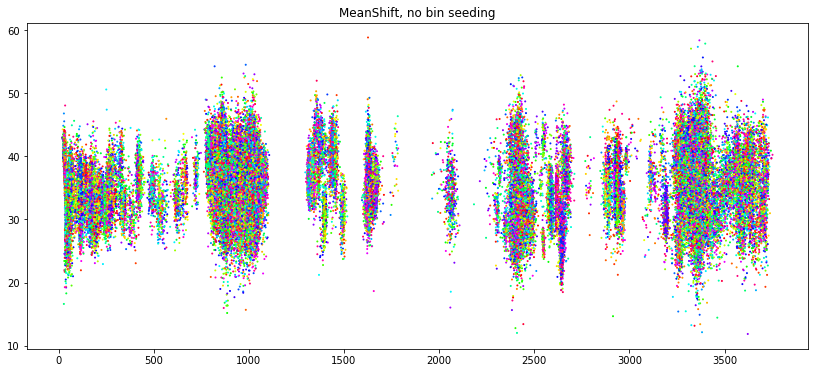

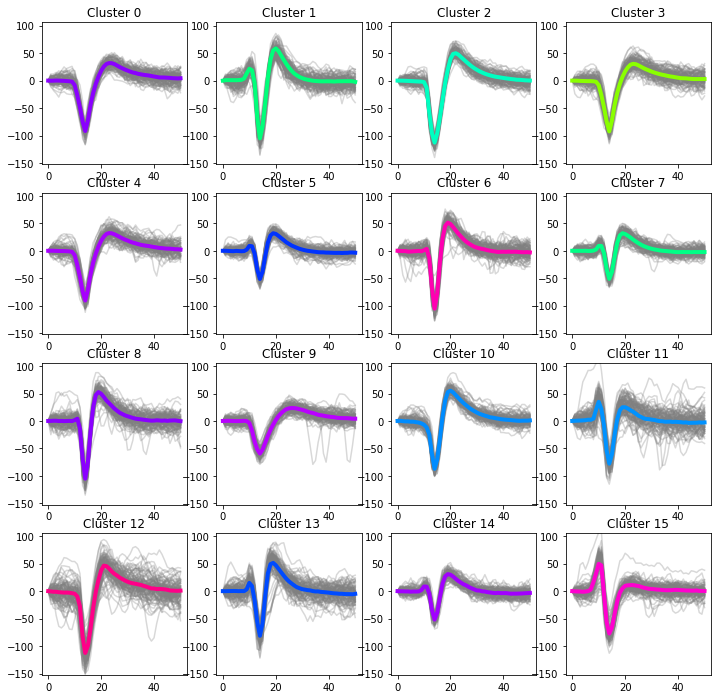

In [30]:
get_cluster(2)

units = range(16)
C.PlotShapes(units)

In [148]:
def PlotClustersLocation(list_of_clusters, invert=True):
    plt.figure(figsize=(8, 6))
    max_shapes=1000
    
    for cl in list_of_clusters:
        cx, cy = C.clusters['ctr_x'][cl], C.clusters['ctr_y'][cl]
        inds = np.where(C.spikes.cl == cl)[0][:max_shapes]
        x, y = C.spikes.x[inds], C.spikes.y[inds]
        plt.scatter(x, y, c=plt.cm.hsv(C.clusters['Color'][cl]), s=3, alpha=0.8)
    plt.show()
            
def PlotClustersFeatures(list_of_clusters, invert=True):
    plt.figure(figsize=(10, 6))
    max_shapes=1000
    
    for cl in list_of_clusters:
        cx, cy = C.clusters['ctr_x'][cl], C.clusters['ctr_y'][cl]
        inds = np.where(C.spikes.cl == cl)[0][:max_shapes]
        x = []
        y = []
        for i in range(enc_2.shape[0]):
            if C.spikes.cl[i] == cl:
                x.append(C.features[i, 0])
                y.append(C.features[i, 1])
                #print(x,y)
        plt.scatter(x, y, c=plt.cm.hsv(C.clusters['Color'][cl]), s=3, alpha=0.8)
    plt.show()

Fitting PCA using 95240 spikes...
...projecting...
...done
Updating features from encoded data
Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  2.7min remaining:  8.2min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  2.8min remaining:   33.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  2.8min finished


Number of estimated units: 549


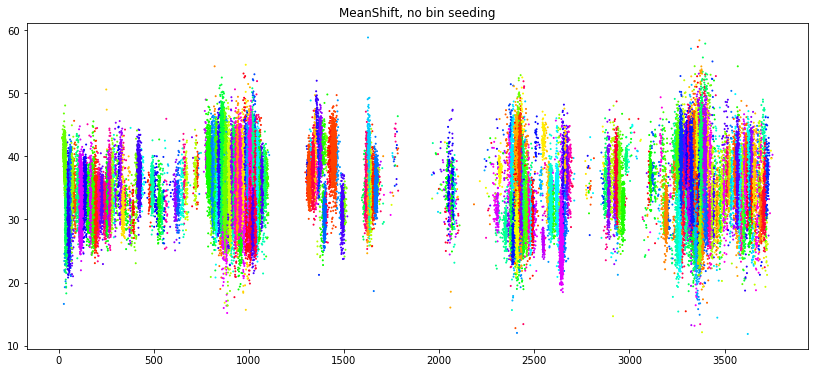

In [149]:
gen_features(enc_2)
get_cluster(0.25)

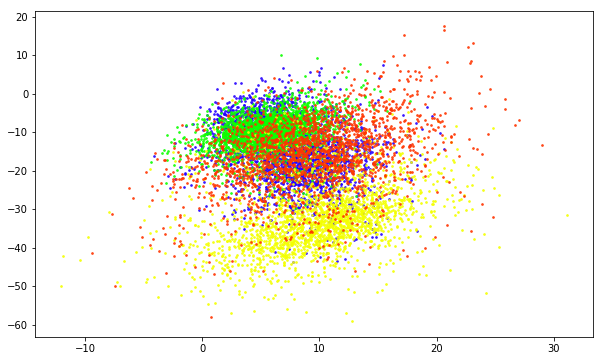

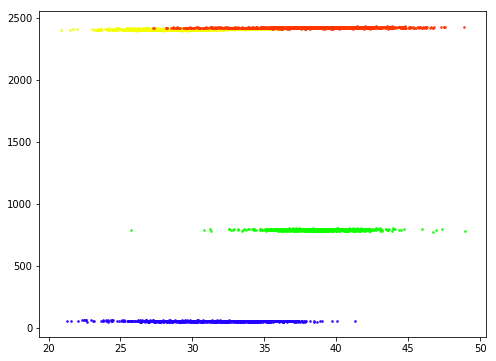

In [150]:
PlotClustersFeatures([1, 2, 4, 9])
PlotClustersLocation([1, 2, 4, 9])

Fitting PCA using 95240 spikes...
...projecting...
...done
Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.6min remaining:  4.9min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  1.7min remaining:   20.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.7min finished


Number of estimated units: 369


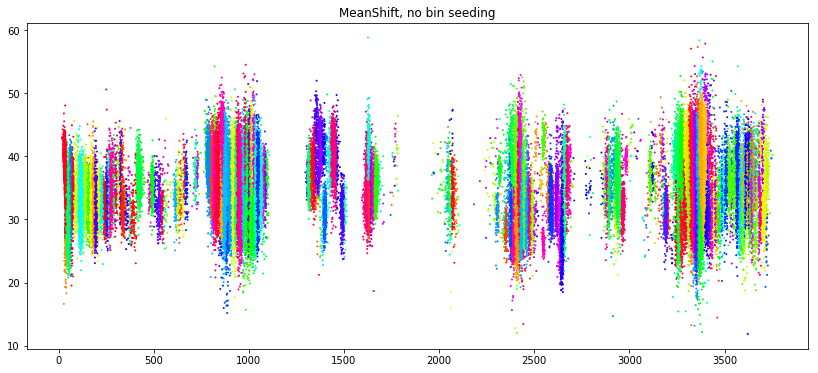

In [153]:
gen_features(enc_2, pca=True)
get_cluster(0.25)

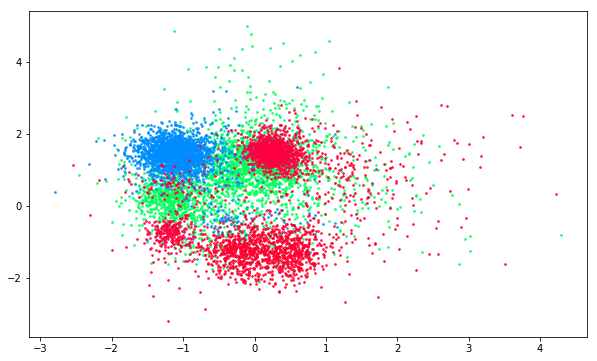

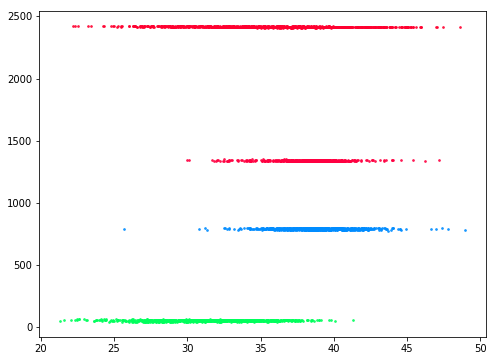

In [154]:
PlotClustersFeatures([1, 2, 4, 9])
PlotClustersLocation([1, 2, 4, 9])